# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `12`
* Students: `Arnaud Duvieusart, Omar Boujdaria, Franck Dessimoz and Adrien Vandenbroucque`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency =  np.load('adj.npy')
n_nodes =  len(adjacency)

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
D = np.diag(np.sum(adjacency, axis=0))

laplacian_combinatorial =  sparse.csr_matrix(D - adjacency)

inverse_sqrt_D = scipy.linalg.inv(scipy.linalg.sqrtm(D))
laplacian_normalized = sparse.csr_matrix(inverse_sqrt_D @ laplacian_combinatorial @ inverse_sqrt_D)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [22]:
laplacian =  laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [23]:
eigenvalues, eigenvectors =  scipy.linalg.eigh(laplacian.toarray())

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

***Since our adjacency matrix is symmetric and we need to compute all the eigenvalues and eigen vectors, we used the eigh() function from scipy.linalg. Indeed, we couldn't use the one from the sparse module since it doesn't allow to compute all the eigenvalues and eigenvectors.***

***We used the eigh() function instead of the eig() function since our adjacency matrix is symmetric.***

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

***$S$ is the incidence matrix, which is defined as follow :***
$S(i,j) = 
     \begin{cases}
       1 &\quad\text{if } e_j = (v_i, v_k)\text{ for some }k \\
       -1 &\quad\text{if } e_j = (v_k, v_i)\text{ for some }k \\
       0 &\quad\text{otherwise}\\
     \end{cases}$


***Thus $S^Tx$ compute the gradient of $x$, where $x$ is a vertex defined on $\mathbb{R}^N$.***

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

***By the definition, $\|S^Tx\|_2^2 = x^TLx$ measures the smoothness of the signal $x$.***

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your annswer here.**

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

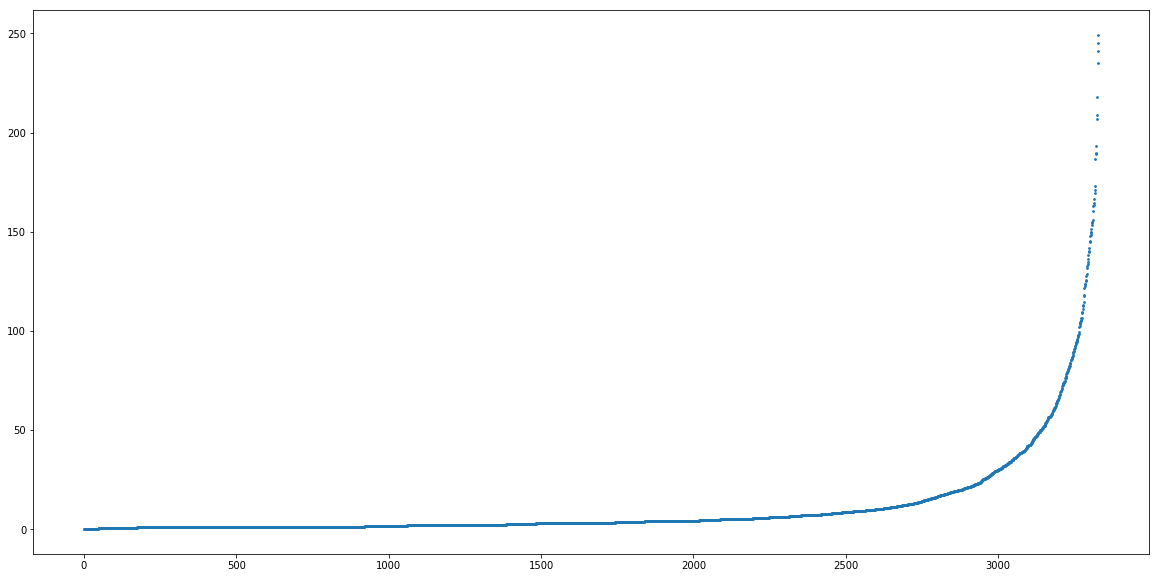

In [27]:
plt.figure(figsize=(20, 10))
plt.scatter(x=list(range(len(eigenvalues))), y=eigenvalues, s=3)
plt.show()

**Your answer here.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [24]:
threshold = 1e-10
eigenvalues = [0 if e < threshold else e for e in eigenvalues]
lambda_0 = np.min(eigenvalues)
n_connected_components = np.count_nonzero(eigenvalues == lambda_0)
print('Number of connected components: ', n_connected_components)

Number of connected components:  7


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

In [26]:
lambda_max = np.max(eigenvalues)
lambda_max

249.2168353102242

***For the normalized Laplacian, as we have seen in class, the largest eigenvalue is 2.***

***For the combinatorial Laplacian, as we have seen in class, the largest eigenvalue seems to be bounded by 250.***

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [47]:
def compute_embedding_fiedler(laplacian, dim, normalized_eig=False):
    k_eigenvalues, k_eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=7+dim, which='SA')
    fiedler_vector = k_eigenvectors[:, n_connected_components]
    if normalized_eig:
        k_eigenvectors = inverse_sqrt_D @ k_eigenvectors

    embedding = np.zeros((n_nodes, dim))
    for i in range(n_nodes):
        for k_th in range(dim): 
            embedding[i, k_th] = k_eigenvectors[i, 7+k_th]
    return embedding, fiedler_vector

In [49]:
embedding_2d, fiedler_vector = compute_embedding_fiedler(laplacian, 2, normalized_eig=True)

In [52]:
km = np.sign(fiedler_vector)

Plot the nodes embedded in 2D. Comment on what you see.

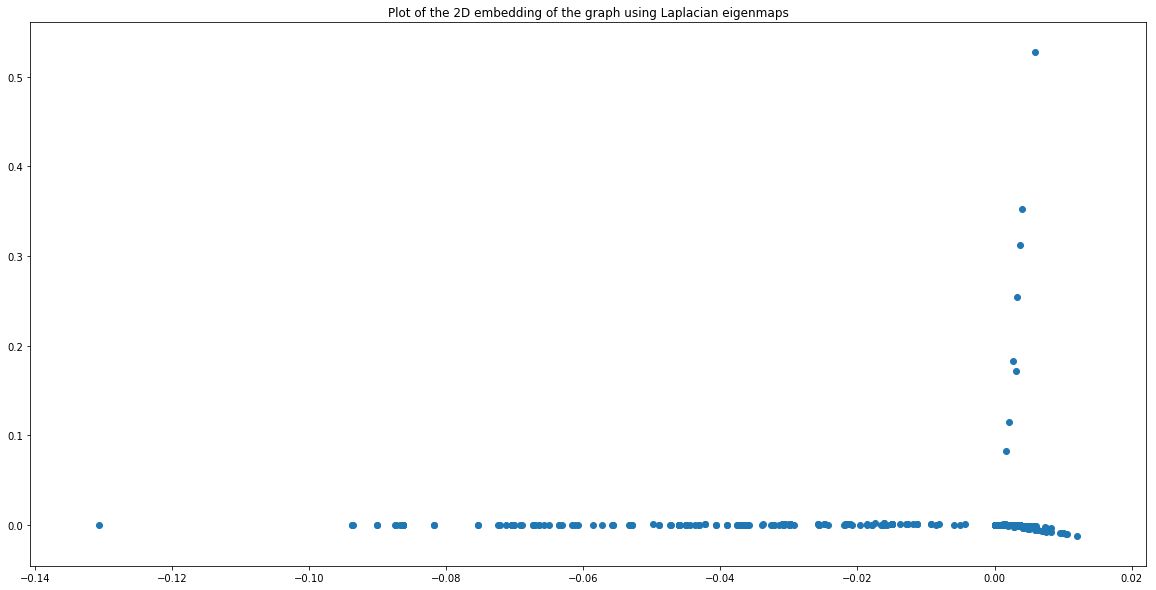

In [34]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])
plt.title('Plot of the 2D embedding of the graph using Laplacian eigenmaps')
plt.show()

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [35]:
nodes_embedded = compute_embedding(laplacian, 7, normalized_eig=True)

[-3.39481372e-15 -1.53594690e-15  2.12239415e-15  2.79120485e-15
  3.98894571e-15  1.10912796e-14  1.23367600e-14  3.90903440e-02
  5.54237524e-02  6.00207016e-02  6.63511487e-02  6.81850328e-02
  8.20238504e-02  8.87035939e-02]


In [38]:
predictions = KMeans(n_clusters=2, random_state=0).fit_predict(nodes_embedded)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

***Since kmeans returns a vectir of size N***

In [39]:
#TODO

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [40]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

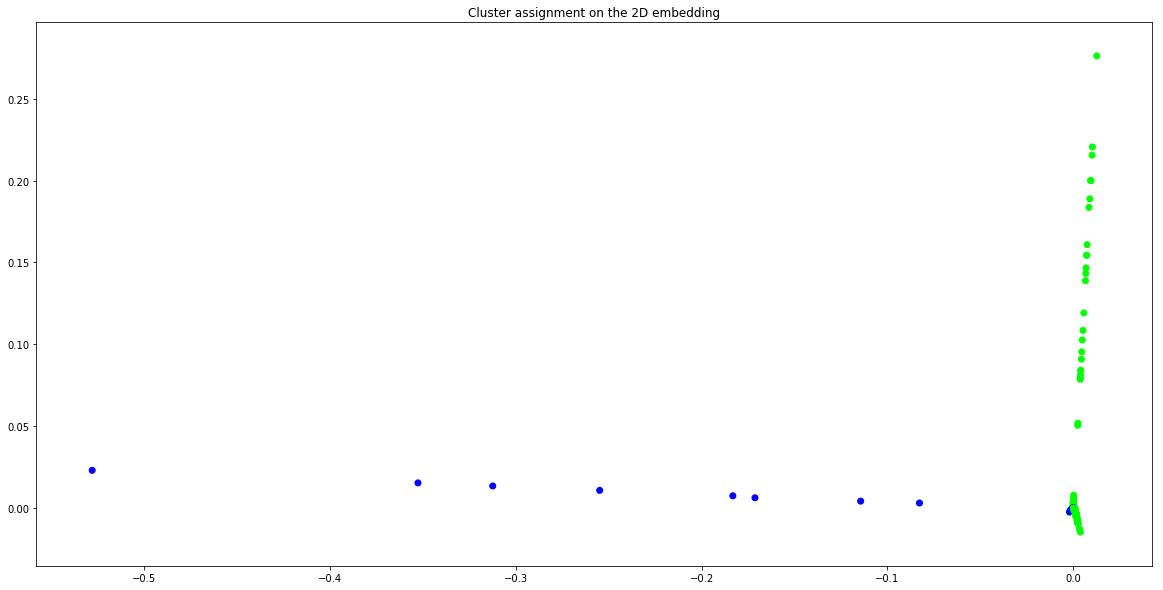

In [53]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=km, cmap='brg')
plt.title("Cluster assignment on the 2D embedding")
plt.show()

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**